## Imports

In [36]:
import os
import math
import keras
import random
import sklearn
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Sequential
from keras.layers import RepeatVector, TimeDistributed, Dense, Dropout
from keras.layers import LSTM, Conv1D, Bidirectional, MaxPooling1D, Flatten

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
# Routine to be sure to get reproductible results
seed_value = 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## 1. Load and format the time series
We start by loading the time series dataset and define the index to be the months.

In [38]:
# Load the dataset
df = pd.read_csv('Data/wisconsin-employment-time-series.csv', header=0, squeeze=True, infer_datetime_format=True)
df = df.rename(columns={'Data': 'Employment figures'})
df['Month'] = pd.DatetimeIndex(df['Month'])
# Set 'Month' to be the index
df = df.set_index('Month')

## 2. Visualize the time series
Before doing any analysis or predictions on the dataset, we visualize the time series and its decomposition into trend and seasonality. The decomposition can be easily done using the __seasonal_decompose__ function from the __statsmodels__ library.

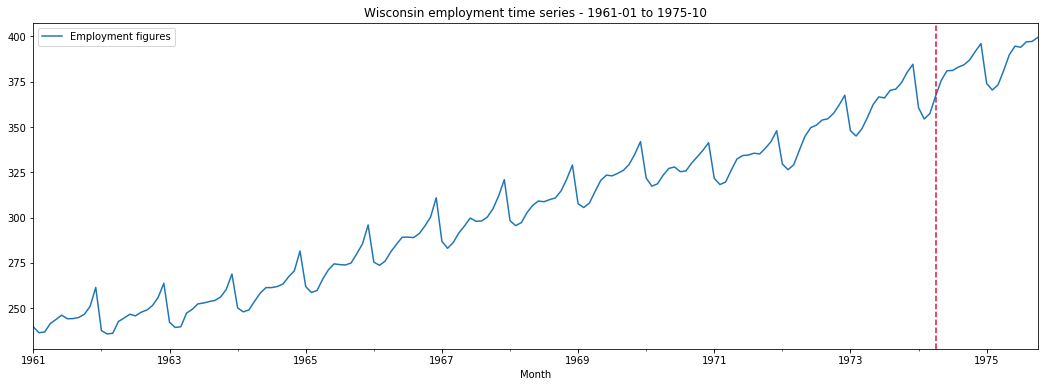

In [39]:
# Plot the time series
df.plot(colormap='tab10')
plt.title('Wisconsin employment time series - 1961-01 to 1975-10')
plt.axvline(x='1974-04', linestyle='--', c='crimson')
plt.gcf().set_size_inches(18,6)
plt.show()

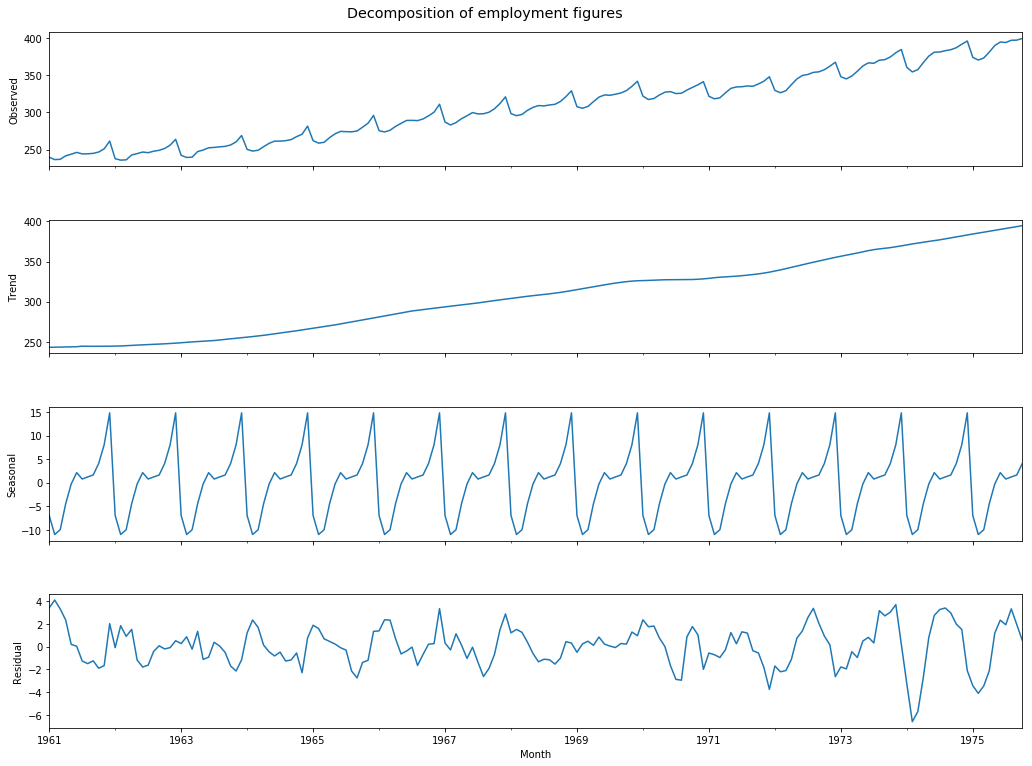

In [40]:
# Decompose time series
decomposition = seasonal_decompose(df, model='additive', extrapolate_trend='freq')

# Plot the decomposition
decomposition.plot()
plt.suptitle('Decomposition of employment figures', size='x-large')
plt.subplots_adjust(top=0.95)
plt.gcf().set_size_inches(16,12)
plt.show()

## 3. Preprocess the time series
The preprocessing of the time series is quiet easy since we will only rescale the value and extract some of them as validation data.

### 3.1 Scaling
Since LSTMs are sensitive to the scale of the input data, it is a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the __MinMaxScaler__ function from the __scikit-learn__ library.

In [41]:
# Scale the values using MinMaxScaler
obs = df['Employment figures'].values
obs = obs.reshape(len(obs), 1)
mm_scaler = MinMaxScaler().fit(obs)
obs_scale = mm_scaler.transform(obs).flatten()

### 3.2 Hide the end of the time series
We hide the last 18 months of the time series in order to predict them and test the accuracy of the models using 4 different metrics score. We will use these last 18 months as validation test.

In [42]:
obs_train = obs_scale[:obs_scale.shape[0]-18]
obs_test = obs_scale[obs_scale.shape[0]-18:]

## 4. Find an optimal model
Given the validation set that we created above, we will test 4 different LSTM architectures and for each of them we will implement 2 different approaches, one static and one dynamic. Thereafter we will compare their accuracy using 4 different metrics.

In [43]:
def split_sequence(sequence, window):
    """ This function splits the time series into a sequence of n_steps values
        used to predict the n_steps + 1 value. This transform the time series
        to a supervised learning problem. """
    # Initialize X and y
    X, y = [], []
    for i in range(len(sequence)):
        # Define the end of the observations
        end = i + window
        # Check for IndexOutOfBounds
        if end > len(sequence)-1:
            break
        # Add the observations sequence and the prediction
        X.append(sequence[i:end])
        y.append(sequence[end])
    # Return X and y
    return np.array(X), np.array(y)

In [44]:
def get_predictions_static(model, obs_train, window, n_predictions, n_epochs, CNN=False):
    """ This function computes the predictions using a model that is trained only
        once on all known values. """
    # Get the observations and the targets
    X_train, y_train = split_sequence(obs_train, window)
    # Reshape to fit the model's input shape
    if(CNN):
        X_train = X_train.reshape((X_train.shape[0], 2, int(window/2), 1))      
    else:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    # Train the model on all known observations
    model.fit(X_train, y_train, epochs=n_epochs, verbose=0)
    # Copy obs_train to append the predictions
    obs_train_ = obs_train.copy()
    for i in range(n_predictions):
        # Get the window-last observations
        X_pred = obs_train_[obs_train_.shape[0]-window:]
        # Reshape to fit the model's input shape
        if(CNN):
            X_pred = X_pred.reshape((1, 2, int(window/2), 1))
        else:
            X_pred = X_pred.reshape((1, len(X_pred), 1))
        # Get the prediction
        y_pred = model.predict(X_pred)
        # Store the prediction to use it as observation in the next step
        obs_train_ = np.append(obs_train_, y_pred)
    return obs_train_

In [45]:
def get_predictions_dynamic(model, obs_train, window, n_predictions, n_epochs, CNN=False):
    """ This function computes the predictions using a model that is trained at
        each time a new predictions get available."""
    # Copy obs_train to append the predictions
    obs_train_ = obs_train.copy()
    for i in range(n_predictions):
        # Get the observations and the targets
        X_train, y_train = split_sequence(obs_train_, window)
        # Reshape to fit the model's input shape
        if(CNN):
            X_train = X_train.reshape((X_train.shape[0], 2, int(window/2), 1))      
        else:
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        # Train the model on all known observations
        model.fit(X_train, y_train, epochs=n_epochs, verbose=0)
        # Get the window-last observations
        X_pred = obs_train_[obs_train_.shape[0]-window:]
        # Reshape to fit the model's input shape
        if(CNN):
            X_pred = X_pred.reshape((1, 2, int(window/2), 1))
        else:
            X_pred = X_pred.reshape((1, len(X_pred), 1))
        # Get the prediction
        y_pred = model.predict(X_pred)
        # Store the prediction to use it as observation in the next step
        obs_train_ = np.append(obs_train_, y_pred)
    return obs_train_

In [46]:
# We will use a window of size 50
window = 50
# Define the number of epochs
n_epochs = 200

### 4.1 Architectures definition
We start by defining the 4 LSTM architectures:
- Vanilla LSTM
- Stacked LSTM
- Bidirectionnal LSTM
- CNN LSTM

The following implementations have been implemented using the help of this tutorial on LSTM development for Time Series. 
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

#### 4.1.1 Vanilla LSTM Architecture
The Vanilla LSTM is the most basic LSTM architecture. It has a single hidden layer of LSTM units, and an output layer used to make a prediction.

In [47]:
# Vanilla LSTM
van_model = Sequential()
van_model.add(LSTM(50, activation='relu', input_shape=(window, 1)))
van_model.add(Dense(1))
van_model.compile(optimizer='adam', loss='mse')
van_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


#### 4.1.2 Stacked LSTM Architecture
A stacked LSTM architecture is such that many hidden layers can be stacked one on top of another.

In [48]:
# Stacked LSTM
st_model = Sequential()
st_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(window, 1)))
st_model.add(LSTM(50, activation='relu'))
st_model.add(Dense(1))
st_model.compile(optimizer='adam', loss='mse')
st_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


#### 4.1.3 Bidirectional LSTM Architecture
In Bidirectional LSTM architecture, we train two instead of one LSTMs on the input sequence. The first on the original input sequence and the second on a reversed copy of the input sequence.

In [49]:
# Bidirectional LSTM
bi_model = Sequential()
bi_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(window, 1)))
bi_model.add(Dense(1))
bi_model.compile(optimizer='adam', loss='mse')
bi_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


#### 4.1.4 CNN LSTM Architecture
The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

In [50]:
# CNN LSTM
cnn_model = Sequential()
cnn_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
                              input_shape=(None, int(window/2), 1)))
cnn_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_model.add(TimeDistributed(Flatten()))
cnn_model.add(LSTM(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 25, 64)      128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 12, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 768)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                163800    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 163,979
Trainable params: 163,979
Non-trainable params: 0
_________________________________________________________________


In [51]:
models = [van_model, st_model, bi_model, cnn_model]

### 4.2 Test the models - Static approach
In this static approach we use the following scheme. We train the model once on the known values and we fit the model to the 50 most recent known values to get the first prediction. Once we have this first prediction, it becomes a known values that we will use to compute the next prediction. Therefore, at the second iterative step, the obsevation will consists of the 49 most recent initially known values plus the first prediction. And we keep going on like this until we have predicted all the missing values. Note that in this model we only train the model once at the begining instead of training it at each iterative step.

In [52]:
# Define the parameters
n_predictions = 18
col_name = ['Vanilla static preds', 'Stacked static preds', 'Bidirectional static preds', 'CNN static preds']

In [53]:
# For each model, get the predictions and store them
for i, model in enumerate(models):
    y_pred = get_predictions_static(model, obs_train, window, n_predictions, n_epochs, CNN=(i==3))
    y_pred_unscale = mm_scaler.inverse_transform(y_pred.reshape((y_pred.shape[0], 1)))
    df[col_name[i]] = y_pred_unscale

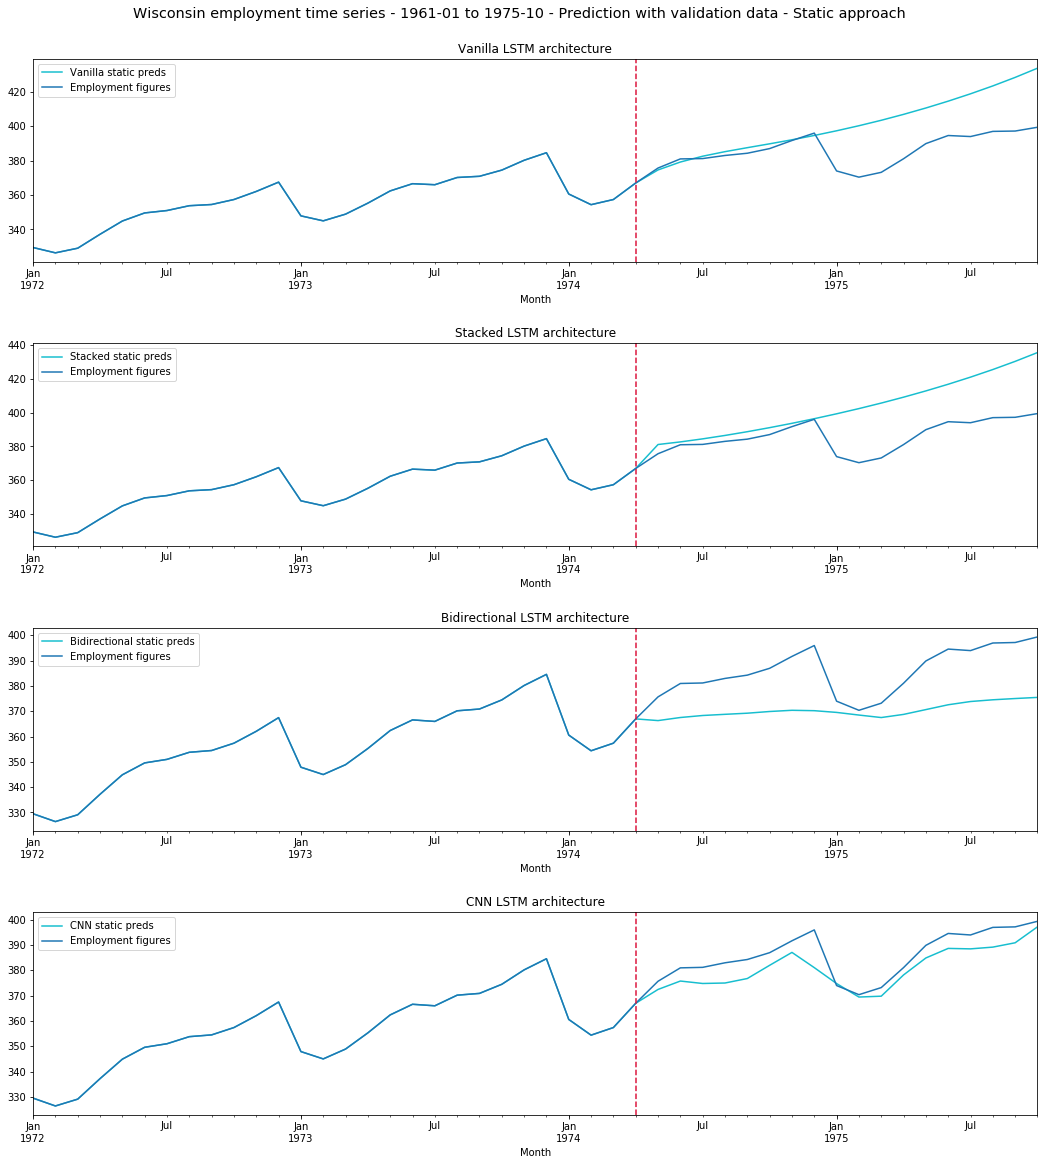

In [54]:
# Plot the result
sub_titles = ['Vanilla LSTM architecture', 'Stacked LSTM architecture',
              'Bidirectional LSTM architecture', 'CNN LSTM architecture']
title = 'Wisconsin employment time series - 1961-01 to 1975-10 - Prediction with validation data - Static approach'
fig, ax = plt.subplots(nrows=len(models))
for i in range(len(models)):
    df[[col_name[i], 'Employment figures']]['1972-01':].plot(ax=ax[i], colormap='tab10_r')
    ax[i].title.set_text(sub_titles[i])
    ax[i].axvline(x='1974-04', linestyle='--', c='crimson')
fig.suptitle(title, fontsize='x-large')
plt.subplots_adjust(hspace=0.4, top=0.94)
plt.gcf().set_size_inches(18, 18)
plt.show()

### 4.3 Test the models - Dynamic approach
In the dynamic approach, instead of training the model only once at the begining with the known values, we train a new model at each time we have computed a new prediction. Hence we will predict the 18 missing values with 18 different models.

In [55]:
# Define the parameters
n_predictions = 18
col_name = ['Vanilla dynamic preds', 'Stacked dynamic preds', 'Bidirectional dynamic preds', 'CNN dynamic preds']

In [56]:
# For each model, get the predictions and store them
for i, model in enumerate(models):
    y_pred = get_predictions_dynamic(model, obs_train, window, n_predictions, n_epochs, CNN=(i==3))
    y_pred_unscale = mm_scaler.inverse_transform(y_pred.reshape((y_pred.shape[0], 1)))
    df[col_name[i]] = y_pred_unscale

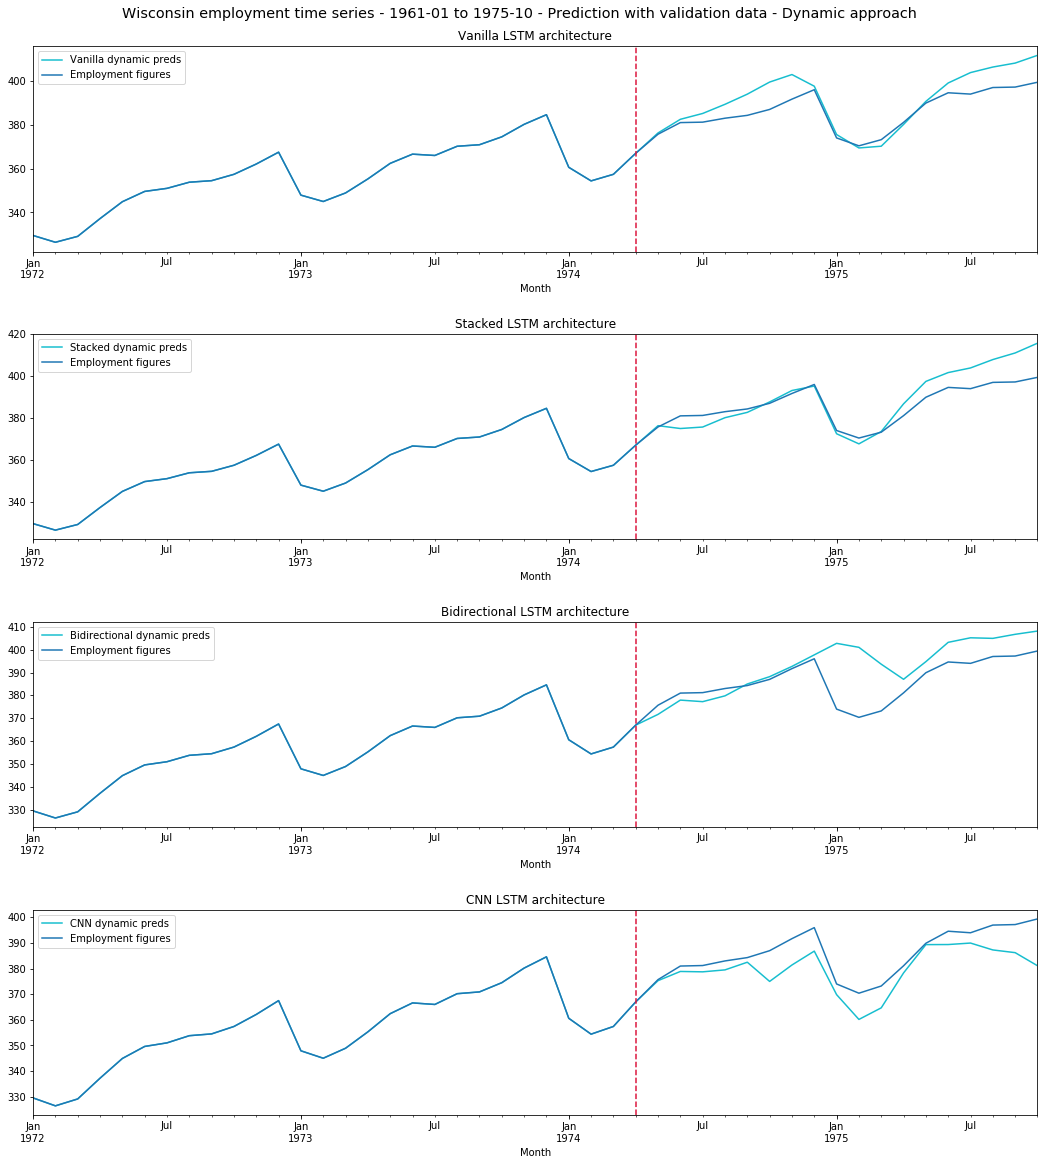

In [57]:
# Plot the result
sub_titles = ['Vanilla LSTM architecture', 'Stacked LSTM architecture',
              'Bidirectional LSTM architecture', 'CNN LSTM architecture']
title = 'Wisconsin employment time series - 1961-01 to 1975-10 - Prediction with validation data - Dynamic approach'
fig, ax = plt.subplots(nrows=len(models))
for i in range(len(models)):
    df[[col_name[i], 'Employment figures']]['1972-01':].plot(ax=ax[i], colormap='tab10_r')
    ax[i].title.set_text(sub_titles[i])
    ax[i].axvline(x='1974-04', linestyle='--', c='crimson')
fig.suptitle(title, fontsize='x-large')
plt.subplots_adjust(hspace=0.4, top=0.95)
plt.gcf().set_size_inches(18, 18)
plt.show()

### 4.4 Compare the accuracy metrics
Now we compare many different metrics in order to evaluate the best model. The best model will be used in the next part to forecast the employment figures over 2 years.
We are going to use 4 different metrics:
- The Mean Forecast Error (or Forecast Bias)
- The Mean Absolute Error
- The Mean Squared Error
- The Root Means Squared Error

In [58]:
def get_pred_metrics(df, y_test, columns):
    """ Given a dataframe with predicted values, the columns' name of the
        predicted values and the validation test, this function computes 4
        different metrics, MFE, MAE, MSE and RMSE. """
    mfes, maes, mses, rmses = [], [], [], []
    for col in columns:
        mfes.append(np.mean(y_test - df[col]))
        maes.append(mean_absolute_error(y_test, df[col]))
        mses.append(mean_squared_error(y_test, df[col]))
        rmses.append(np.sqrt(mean_squared_error(y_test, df[col])))
    return mfes, maes, mses, rmses

In [59]:
# Define the initial values
y_test = df['Employment figures']
# Get the metrics for the static models
columns_static = df.columns.values[1:5]
mfes_static, maes_static, mses_static, rmses_static = get_pred_metrics(df, y_test, columns_static)
# Get the metrics for the dynamic models
columns_dynamic = df.columns.values[5:9]
mfes_dynamic, maes_dynamic, mses_dynamic, rmses_dynamic = get_pred_metrics(df, y_test, columns_dynamic)

In [60]:
# Construct a dataframe to show the result
metrics = {'Static MFE': mfes_static,
           'Static MAE': maes_static,
           'Static MSE': mses_static,
           'Static RMSE': rmses_static,
           'Dynamic MFE': mfes_dynamic,
           'Dynamic MAE': maes_dynamic,
           'Dynamic MSE': mses_dynamic,
           'Dynamic RMSE': rmses_dynamic}
index = ['Vanilla', 'Stacked', 'Bidirectional', 'CNN']
df_comp = pd.DataFrame(metrics)
df_comp.index = index
df_comp

,Static MFE,Static MAE,Static MSE,Static RMSE,Dynamic MFE,Dynamic MAE,Dynamic MSE,Dynamic RMSE
Vanilla,-1.530659,1.578895,41.259348,6.423344,-0.514743,0.569721,5.192404,2.278685
Stacked,-1.750850,1.750850,47.862566,6.918278,-0.298296,0.536009,5.089291,2.255946
Bidirectional,1.591102,1.591102,29.790117,5.458032,-0.712234,0.871977,15.299981,3.911519
CNN,0.527853,0.536806,3.841641,1.960010,0.652728,0.652728,6.490163,2.547580


## 5. Two years forecast
Now that we have tested our models with validation data, we are going to forecast the employment figures over the 2 next years, i.e. 24 values - 1 per month. We will use the same argument as before, i.e. we always use a windows size of 50 values to predict the new one, and once we have a new prediction we add it to the known values and move forward the window.

In [61]:
# Use a copy of the original dataset
df_forecast = df[['Employment figures']]
# Add the dates for the next 24 months
datelist = [d.strftime('%Y-%m-01') for d in pd.date_range('1975-11', periods=24, freq='M').tolist()]
df_ = pd.DataFrame(datelist)
dt_index = pd.DatetimeIndex(df_[0])
df_forecast = df_forecast.append(pd.DataFrame(np.zeros(len(dt_index)), index=dt_index, columns=['Employment figures']))

In [62]:
# Define the parameters
n_predictions = 24
col_name = ['Vanilla forecast', 'Stacked forecast','Bidirectional forecast', 'CNN forecast']

In [63]:
# For each model, get the predictions and store them
for i, model in enumerate(models):
    y_pred = get_predictions_dynamic(model, obs_scale, window, n_predictions, n_epochs, CNN=(i==3))
    y_pred_unscale = mm_scaler.inverse_transform(y_pred.reshape((y_pred.shape[0], 1)))
    df_forecast[col_name[i]] = y_pred_unscale

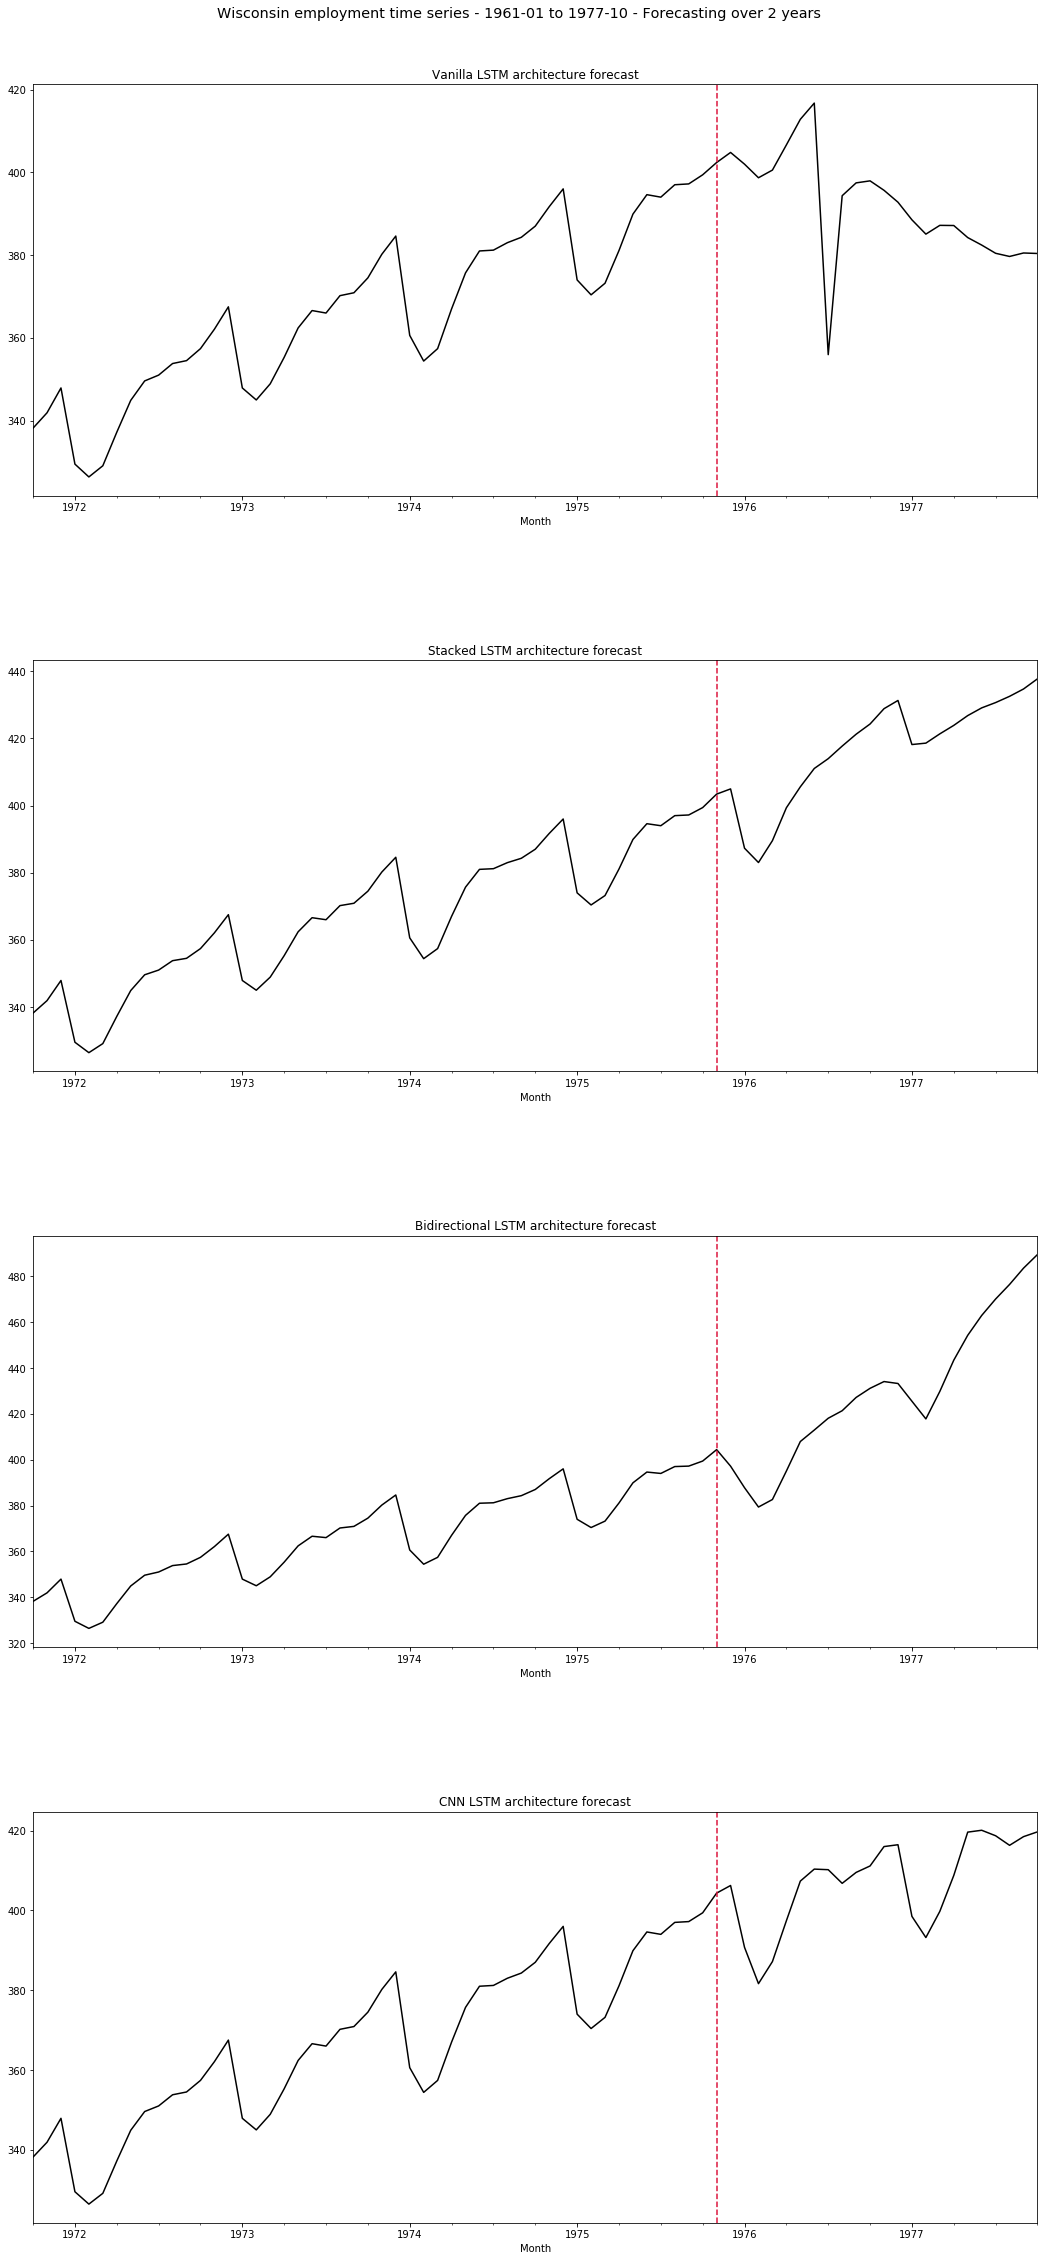

In [68]:
# Plot the result
sub_titles = ['Vanilla LSTM architecture forecast', 'Stacked LSTM architecture forecast',
              'Bidirectional LSTM architecture forecast', 'CNN LSTM architecture forecast']
title = 'Wisconsin employment time series - 1961-01 to 1977-10 - Forecasting over 2 years'
fig, ax = plt.subplots(nrows=len(models))
for i in range(len(models)):
    df_forecast['1971-10':][col_name[i]].plot(ax=ax[i], colormap='gray')
    ax[i].title.set_text(sub_titles[i])
    ax[i].axvline(x='1975-11', linestyle='--', c='crimson')
    ax[i].set_xlabel('Month')
fig.suptitle(title, fontsize='x-large')
plt.subplots_adjust(hspace=0.4, top=0.95)
plt.gcf().set_size_inches(18, 36)
plt.show()